In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:16.3f}'.format}, linewidth=130)

In [40]:
def identity(x):
    return x

def relu(x):
    
    # One line return statement is dope!
    return np.where(x > 0, x, 0)

def l_relu(x, a = 0.01):
    
    # One line return statement is dope!
    return np.where(x > 0, x, a*x)

def natural_l_relu(x, a = 0.01, b = 1):
    return np.where(x > b, np.log(np.abs(x)), a * x)

def exp_relu(x, a = 0.6):
    return np.where(x >= 0, np.power(x, a), -np.power(-x, a))

def sech(x):
    return 2 * np.exp(x)/(np.exp(2*x) + 1)

def sine(x):
    
    return np.sin(x)

def cos(x):
    
    return np.cos(x)

def tanh(x):
    return np.tanh(x)

def sigmoid(x):
    return 1/(1+np.exp(-x))

def cont_sigmoid(x):
    return sigmoid(x)*x+x/4

def exp_div(x):
    return 1/np.exp(x)

# The method for producing generalaized fourier waves!
def randomFourier(x, period = 10, limit1 = 100, limit2 = 100, bias = 0.0007, coef1 = 0.001, coef2 = 0.0001):
    #period = np.random.normal(1000, 1000)
    #coef1 = np.random.normal(1000, 1000)
    #coef2 = np.random.normal(1000, 1000)
    
    #limit1 = np.random.randint(1000)
    #limit2 = np.random.randint(1000)
    #bias = np.random.normal(1000, 1000)
    
    x = np.matrix(np.array(x).flatten()).T
    r1 = np.matrix(np.linspace(0, limit1, num = limit1)) +1
    
    r2 = np.matrix(np.linspace(0, limit2, num = limit2)) +1
    
    x_expanded1 = np.multiply(r1, x)
    x_expanded2 = np.multiply(r2, x)
    sine_part = coef1 * np.sum(np.sin(x_expanded1) * np.pi/(period/2), axis = 1)
    cos_part = coef2 * np.sum(np.cos(x_expanded2) * np.pi/(period/2), axis = 1)
    return np.squeeze(np.array(sine_part + cos_part + bias))

In [41]:
a = np.array([1, 2, 3])
randomFourier(a)

array([           0.001,            0.001,            0.001])

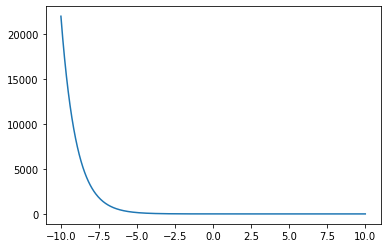

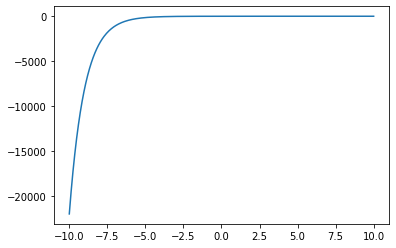

C:\Users\joels\AppData\Local\Temp\ipykernel_2084\2911018045.py:18: RuntimeWarning: invalid value encountered in power
  return np.where(x >= 0, np.power(x, a), -np.power(-x, a))


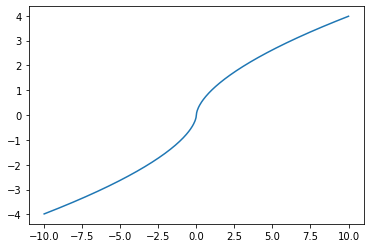

C:\Users\joels\AppData\Local\Temp\ipykernel_2084\2911018045.py:18: RuntimeWarning: invalid value encountered in power
  return np.where(x >= 0, np.power(x, a), -np.power(-x, a))


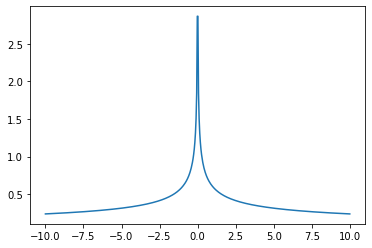

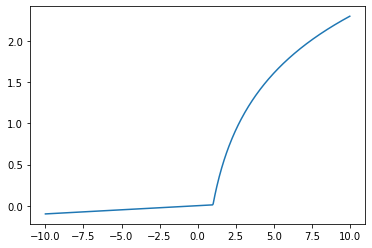

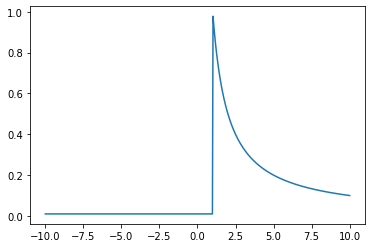

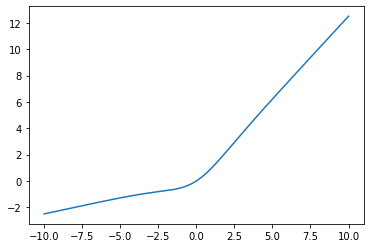

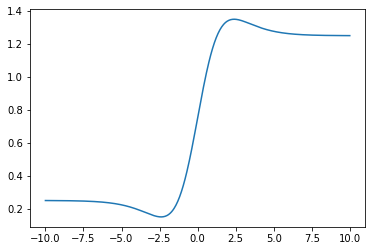

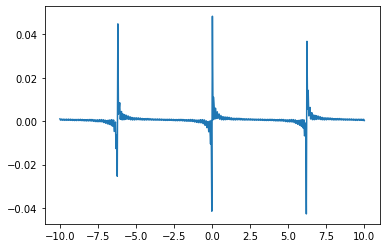

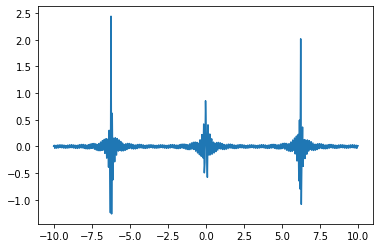

In [42]:
# Experimental: Yield the approximation of the derivative of function f at point x
def get_derivative(f, x, offset = 0.0001):
    
    # Define points between which derivative is approximated
    vec1 = np.array([x - offset, f(x - offset)])
    vec2 = np.array([x + offset, f(x + offset)])
    
    # Get the vector between the two points
    sub = vec2 - vec1
    
    # Return the slope (rise over run echoes in your head)
    return sub[1]/(sub[0] + (offset * 0.001))


activation = exp_div
# Method used for mapping multiple values to the get_derivative method.
def test_approximation(x):
    return get_derivative(activation, x)

limit = 10
line = np.linspace(-limit, limit, num = 500)

plt.plot(line, list(map(activation, line)))
plt.show()
plt.plot(line, list(map(test_approximation, line)))
plt.show()

activation = exp_relu
plt.plot(line, list(map(activation, line)))
plt.show()
plt.plot(line, list(map(test_approximation, line)))
plt.show()

activation = natural_l_relu
plt.plot(line, list(map(activation, line)))
plt.show()
plt.plot(line, list(map(test_approximation, line)))
plt.show()

activation = cont_sigmoid
plt.plot(line, list(map(activation, line)))
plt.show()
plt.plot(line, list(map(test_approximation, line)))
plt.show()

activation = randomFourier
plt.plot(line, list(map(activation, line)))
plt.show()
plt.plot(line, list(map(test_approximation, line)))
plt.show()

In [43]:
y_t = 10
def radial_basis_function(x, sig = 0.3):
    return np.exp(-np.power((np.abs(x - y_t) * sig), 2))

In [44]:
for i in range(10):
    y_t = i
    print(radial_basis_function(np.array([0])))

[           1.000]
[           0.914]
[           0.698]
[           0.445]
[           0.237]
[           0.105]
[           0.039]
[           0.012]
[           0.003]
[           0.001]


# Loss functions

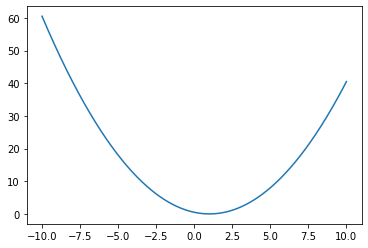

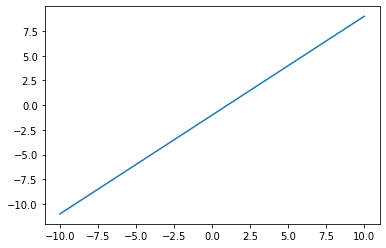

In [45]:
class MSE:
    def __init__(self):
        
        self.y_t = None
        self.batch_y_t = None
    def loss(self, y_p):

        error = np.square(y_p - self.y_t) * 1/(2 * y_p.size)
        return np.nan_to_num(error)
        
    def compute(self, y_p, y_t):
        self.y_t = y_t
            
        return self.loss(y_p)
    
    def derivative(self, x):
        x = x.ravel()
        return get_derivative(self.loss, x)
            
    def set_latent_points(self, points):
        pass
        
mse = MSE()
activation = mse.loss
mse.y_t = 1
plt.plot(line, list(map(activation, line)))
plt.show()
plt.plot(line, list(map(test_approximation, line)))
plt.show()

In [46]:
class Cluster:
    def __init__(self, points, n = 3):
        self.points = points
        self.connections = []
        self.connection_labels = []
        self.num_neighbours = n
        
        self.y_t = None
        self.batch_y_t = None
        self.current_label = None
        
    def set_latent_points(self, points):
        self.points = points
    
    def set_y(self, y):
        self.y_t = y
        
    def compute_min_connections(self):
        connections = []
        connection_labels = []

        # prims algorithm for min spann tree
        tree = [0]
        visited = np.zeros(len(self.points)).astype("bool")
        visited[tree[0]] = True
        
        for i, point in enumerate(self.points):
            dists = []
            for node in tree:
                
                dists.append(np.linalg.norm(np.subtract(self.points, self.points[node]), axis = 1))
                dists[-1][visited] = np.inf
            
            min_dist = np.argmin(dists)
            
            y = int(min_dist/len(self.points))
            x = min_dist % len(self.points)
            tree.append(x)
            visited[x] = True
            connections.append([self.points[x], self.points[tree[y]]])
            connection_labels.append([self.batch_y_t [x].astype("int32"), self.batch_y_t [tree[y]].astype("int32")])
        
        self.connections = connections
        self.connection_labels = connection_labels
        
    def draw_space(self):
        colors = np.array(["blue", "yellow", "green", "red", "cyan", "magenta"])
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        for i, conn in enumerate(self.connections):
            conn = np.array(conn)
            ax.plot(conn.T[0], conn.T[1], conn.T[2], "black")
            
            ax.scatter(conn.T[0], conn.T[1], conn.T[2], c = colors[self.connection_labels[i]], s = 100)
            
        plt.show()
        
    def loss(self, y_p):
        
        # flat vector
        y_p = y_p.flatten()
        
        # get the n nearest neighbours
        
        # The 0 will be the distance to self
        dists = np.linalg.norm((self.points - y_p), axis = 1)
        sorted_indices = np.argsort(dists)
        n = self.num_neighbours + 1
        n_dists = dists[sorted_indices[1:n]]
        
        neighbour_labels = self.batch_y_t [sorted_indices].astype("int")[1:n]
        
        error_dists = n_dists[neighbour_labels != self.current_label]
        
        if len(error_dists) < 1:
            error = np.zeros_like(y_p)
        
        else:
            class_points = self.points[sorted_indices[1 : n]]
            class_points = class_points[neighbour_labels == self.current_label]
            error = np.sum(np.subtract(class_points, y_p), axis = 0)
            
        error = error.reshape(len(error), )
        return np.nan_to_num(error)
        
    def compute(self, y_p, y_t):
        self.current_label = y_t
        return self.loss(y_p)
    
    def derivative(self, x):
        x = x.ravel()
        return get_derivative(self.loss, x)
    
    def evaluate(self, y_p):
        dists = np.linalg.norm((self.points - y_p), axis = 1)
        
        sorted_indices = np.argsort(dists)
        n = self.num_neighbours + 1
        
        neighbours = self.batch_y_t [sorted_indices].astype("int")[1:n]
        counts = np.bincount(self.batch_y_t)
        
        rate = []
        for i in range(len(counts)):
            
            rate.append(len(neighbours[neighbours == i]))
        
        rate = np.array(rate)
        rate = rate/ np.sum(rate)
        
        return rate
        

[           6.282            3.036            6.835]
Der: [          -4.998           -4.998           -4.998]


C:\Users\joels\AppData\Local\Temp\ipykernel_2084\3933826340.py:49: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


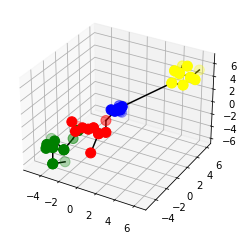

In [47]:
np.random.seed(0)
numbers = 10
points = np.random.random_sample((numbers, 3))
points = np.vstack([points, np.random.normal(5, 0.7, size = (numbers, 3))])
points = np.vstack([points, np.random.normal(-3, 1.7, size = (numbers, 3))])
points = np.vstack([points, np.random.normal(1, 1.05, size = (numbers, 3))-3])

labels = np.ones(numbers) * 0
labels = np.hstack([labels, np.ones(numbers) * 1])
labels = np.hstack([labels, np.ones(numbers) * 2])
labels = np.hstack([labels, np.ones(numbers) * 3])

c = Cluster(points, n = 13)
c.set_y(labels)
y_p = np.array([3, 3, 3]) * -1
y_t = 3
c.batch_y_t = labels
print(c.compute(y_p, y_t))
print("Der:",c.derivative(y_p))
#activation = c.loss
#limit = 10
#line = np.linspace(-limit, limit, num = 10)
#plt.plot(line, list(map(activation, line)))
#plt.show()
#plt.plot(line, list(map(test_approximation, line)))
#plt.show()

c.compute_min_connections()

c.draw_space()

C:\Users\joels\AppData\Local\Temp\ipykernel_2084\699125657.py:48: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


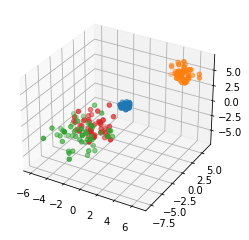

C:\Users\joels\AppData\Local\Temp\ipykernel_2084\699125657.py:67: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


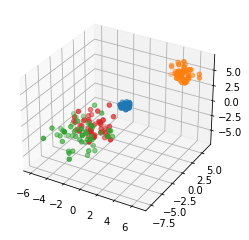

C:\Users\joels\AppData\Local\Temp\ipykernel_2084\699125657.py:74: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


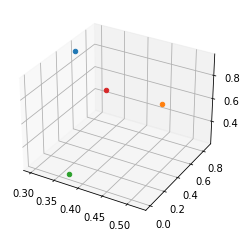

C:\Users\joels\AppData\Local\Temp\ipykernel_2084\699125657.py:83: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


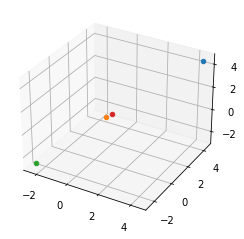

C:\Users\joels\AppData\Local\Temp\ipykernel_2084\699125657.py:91: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


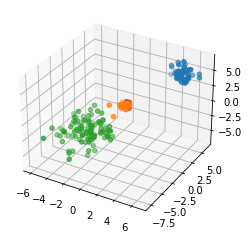

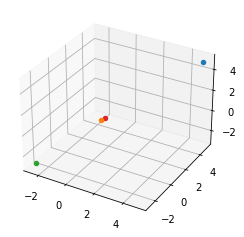

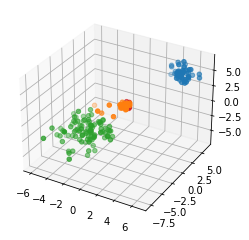

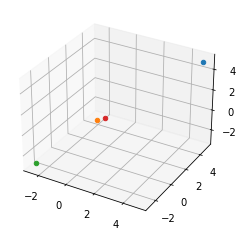

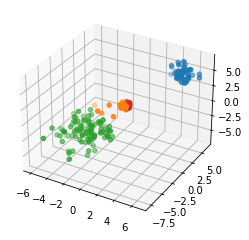

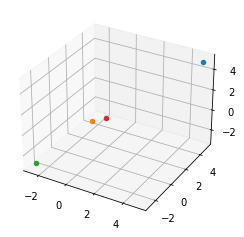

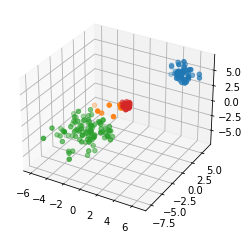

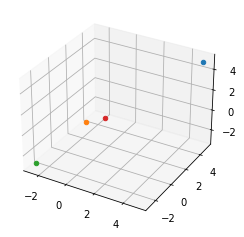

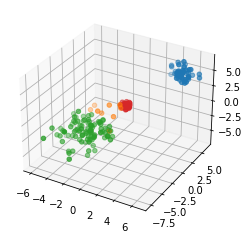

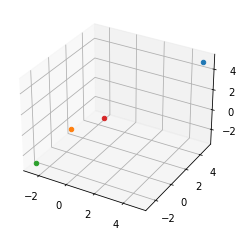

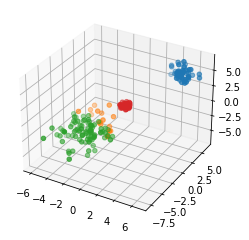

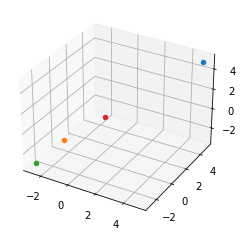

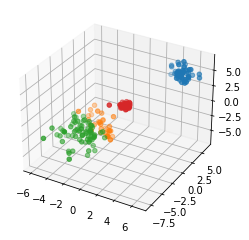

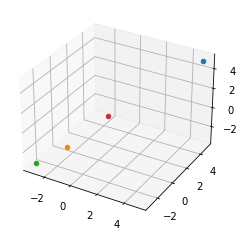

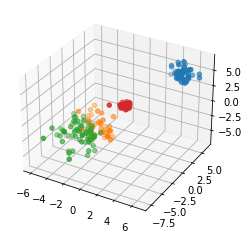

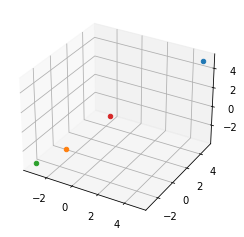

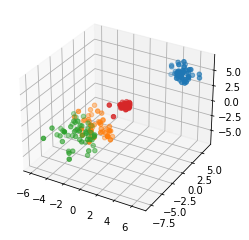

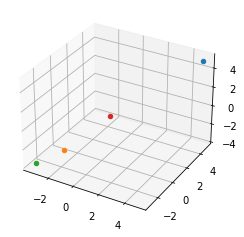

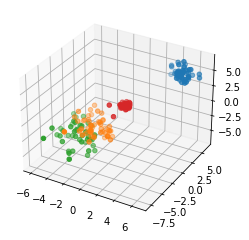

In [48]:
def k_medians(clusters, points, iters = 10, method = np.median):
    
    for i in range(iters):
        
        cluster_points = get_cluster_belonging(clusters, points)

        for c in range(len(clusters)):

            clusters[c] = method(cluster_points[c], axis = 0)
    
    return clusters

def get_cluster_belonging(clusters, points):
    cluster_points = [[] for i in range(len(clusters))]
    for e in points:

        minimum_distance = None

        cluster_dists = []

        for cluster in clusters:

            dist = np.sqrt(np.sum(np.power(cluster - e, 2)))
            #y_t = cluster
            #dist = radial_basis_function(cluster - e, sig = 10)
            #dist = np.sqrt(np.sum(np.power(dist, 2)))
            cluster_dists.append(dist)
        
        index = np.argmin(cluster_dists)

        cluster_points[index].append(e)
        
    return cluster_points

np.random.seed(0)
numbers = 50
points = np.random.random_sample((numbers, 3))
points = np.vstack([points, np.random.normal(5, 0.7, size = (numbers, 3))])
points = np.vstack([points, np.random.normal(-3, 1.7, size = (numbers, 3))])
points = np.vstack([points, np.random.normal(1, 1.05, size = (numbers, 3))-3])

labels = np.ones(numbers) * 0
labels = np.hstack([labels, np.ones(numbers) * 1])
labels = np.hstack([labels, np.ones(numbers) * 2])
labels = np.hstack([labels, np.ones(numbers) * 3])

fig = plt.figure()
ax = fig.gca(projection='3d')
for i in np.unique(labels):
    p = points[labels == i]
    ax.scatter(p.T[0], p.T[1], p.T[2])
plt.show()

#points = np.array(list(map(sigmoid, points)))
#points = np.array(list(map(exp_relu, points)))
#points = np.array(list(map(l_relu, points)))
#points = np.array(list(map(tanh, points)))
#points = np.array(list(map(exp_relu, points)))
#points = np.array(list(map(cos, points)))
#points = np.array(list(map(sine, points)))
#points = np.array(list(map(sech, points)))
#points = np.array(list(map(natural_l_relu, points)))

clusters = np.random.random_sample((4, 3))

fig = plt.figure()
ax = fig.gca(projection='3d')
for i in np.unique(labels):
    p = points[labels == i]
    ax.scatter(p.T[0], p.T[1], p.T[2])
plt.show()

fig = plt.figure()
ax = fig.gca(projection='3d')

for c in clusters:
    ax.scatter(c[0], c[1], c[2])
plt.show()
    
for i in range(10):
    k_medians(clusters, points, iters = 1, method = np.mean)
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    for c in clusters:
        ax.scatter(c[0], c[1], c[2])
    plt.show()


    point_array = get_cluster_belonging(clusters, points)
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    for c in point_array:
        if len(c) > 0:
            ax.scatter(np.array(c).T[0], np.array(c).T[1], np.array(c).T[2])
    plt.show()


# Layer classes


In [49]:
# Super class of layers
class Layer():
    
    def __init__(self, size = None, W = None, activation = None, trainable = None, rate = 0.4, a = 0, standardize = False, iters = 0):
        
        self.size = size
        self.W = W
        self.activation = activation
        self.trainable = trainable
        self.rate = rate
        self.a = a
        self.standardize = standardize
        self.iters = iters
        
        self.signal = None
        self.derivative = None
        self.gradient = []
        
        
    def get_params(self):
        pass

In [50]:
class scaling:
    def __init__(self, size = 3, W = None):
        
        if W is None:
            self.W = np.random.random_sample((size, 1)) * 10 - 5
        else:
            self.W = W
        
        self.W = self.W.reshape((self.W.size, 1))
            
        self.gradients = []
        
    def get_params(self):
        return self.W 
    
    def feed_forward(self, inp, train = True):
        
        self.signal = inp.reshape(inp.size, 1)
        
        if train:
            self.derivative = self.W.reshape(self.W.size, 1)
        
        return np.squeeze(np.multiply(self.signal, self.W))

    def compute_gradient(self, err):
        
        error = err.reshape(err.size, 1)
        
        # Derivative w.r.t. W
        derivative = self.signal
        
        # Gradient is used to update alpha value
        gradient = error * derivative.reshape(derivative.size, 1)

        # Gradient w.r.t Input
        error = error * self.derivative.reshape(self.derivative.size, 1)
        
        self.gradients.append(gradient)
        
        return (error)
    
    def update(self, alpha):
        for gradient in self.gradients:
            self.W += -alpha * gradient * 1/len(self.gradients)
            
        # Remember to reset gradient after update
        self.gradients = []

In [51]:
class dropout:
    
    def __init__(self, rate = 0.1):
        
        self.rate = rate
        self.W = []
        self.mask = None
        
    def get_params(self):
        return self.W   
    
    def feed_forward(self, inp, train = True):
        
        self.signal = inp
        
        if train == False:
            return self.signal
    
        self.mask = np.random.random_sample(inp.shape)
        
        self.mask = np.where(self.mask > self.rate, 1, 0)
        
        return np.multiply(inp, self.mask)
    
    def compute_gradient(self, err):
        
        return err
    
    def update(self, alpha):
        return None

In [52]:
class leaky_relu:
    def __init__(self, size, a = None):
        
        if a == None:
            self.W = np.random.random_sample((size, 1))
        else:
            self.W = np.ones(size) * a
            
        def leaky_relu(x):
            ind = np.argwhere(x < 0)
            x[ind] = self.W.reshape(x.shape)[ind] * x[ind]
            signal = x
            
            return np.array(signal)
        
        self.gradients = []
        self.signal = None
        self.activation = leaky_relu
        
    
    def get_params(self):
        return self.W
    
    def feed_forward(self, inp, train = True):
        
        self.signal = np.array(inp)
        if train:
            self.derivative = get_derivative(self.activation, self.signal)
            self.derivative = np.array(self.derivative).T
        
        return self.activation(inp)
    
    
    def compute_gradient(self, err):
        
        error = err.reshape(err.size, 1)
        
        # Derivative w.r.t. W
        derivative = np.where(self.signal > 0, 0, self.signal)
        
        # Gradient is used to update alpha value
        gradient = error * derivative.reshape(derivative.size, 1)

        # Error is use dto update layers after this
        error = error * self.derivative.reshape(self.derivative.size, 1)
        
        self.gradients.append(gradient)
        
        return (error)
        
    def update(self, alpha):
        for gradient in self.gradients:
            self.W += -alpha * gradient * 1/len(self.gradients)
            
        # Remember to reset gradient after update
        self.gradients = []

In [53]:
class normalization_layer:
    def __init__(self, W= None, learnable = True):
        
        if W== None:
            self.W = np.random.random_sample() * 0.01
        else:
            self.W = W
        
        def activation(x):
            return x * self.W
        
        self.gradients = []
        self.signal = None
        self.activation = activation
        self.learnable = learnable
    
    def get_params(self):
        return self.W
    
    def feed_forward(self, inp, train = True):
        
        self.signal = np.array(inp)
        
        if train:
            self.derivative = get_derivative(self.activation, self.signal)
            self.derivative = np.array(self.derivative).T
        
        return self.activation(inp)
    
    
    def compute_gradient(self, err):
        
        error = err.reshape(err.size, 1)
        
        # Derivative w.r.t. W
        derivative = np.ones(err.size) * self.signal
        
        # Gradient is used to update alpha value
        gradient = error * derivative.reshape(derivative.size, 1)
        gradient = np.mean(gradient)

        # Error is used to update layers after this
        error = error * self.derivative.reshape(self.derivative.size, 1)
        
        self.gradients.append(gradient)
        
        return (error)
        
    def update(self, alpha):
        if self.learnable:
            for gradient in self.gradients:
                self.W += -alpha * gradient * 1/len(self.gradients)
            
        # Remember to reset gradient after update
        self.gradients = []

In [54]:
class zscore_layer:
    def __init__(self, W = None, learnable = False):
        
        if learnable == False:
            self.W = [0, 1]
            def activation(x):
                return (x - np.mean(x))/ np.std(x)
            
        elif W is not None:
            self.W = W
            def activation(x):
                return (x - self.W[0])/ self.W[1]
        
        else:
            self.W = np.random.sample(2)
            def activation(x):
                return (x - self.W[0])/ self.W[1]
        
        
        
        self.gradients = []
        self.signal = None
        self.activation = activation
        self.learnable = learnable
    
    def get_params(self):
        return self.W
    
    def feed_forward(self, inp, train = True):
        
        self.signal = np.array(inp)
        
        if train:
            # Derivative must be taken with respect to each element in vector x separately
            # compute derivative manually here
            # Derivative of mean w.r.t any given x_i is always 1/len(x)
            mean = np.mean(self.signal)
            std = np.std(self.signal)
            n = len(self.signal)

            std_der = (1/(2 * std)) * (2/n) * (self.signal - mean) * (1 - (1/n))
            derivative = (-1/(2*(std**2)) * std_der * (self.signal - mean)) + (1/std * (1 - 1/n))

            self.derivative = derivative
        
        return self.activation(inp)
    
    
    def compute_gradient(self, err):
        
        error = err.reshape(err.size, 1)
        
        # Derivative w.r.t mean and std (made independent for simplicity)
        
        der_mean = -1/self.W[1]
        
        der_std = (1/(self.W[1]**2)) * np.mean((self.signal - self.W[0]))
        
        self.gradients.append(np.array([der_mean, der_std]))
        
        # Derivative w.r.t. x
        error = error * self.derivative.reshape(self.derivative.size, 1)
        
        return (error)
        
    def update(self, alpha):
        if self.learnable:
            for gradient in self.gradients:
                self.W += -alpha * gradient * 1/len(self.gradients)
            
        # Remember to reset gradient after update
        self.gradients = []

In [55]:
class fullyConnected:
    def __init__(self, size, activation = identity, W = None, standardize = False, trainable = True):
        
        if W == None:
            size = (size[0], size[1]+1)
            self.W = np.random.normal(loc = 0, scale = 2/(size[0] + size[1]+1), size = size)
        else:
            self.W = W
        
        self.activation = activation
        
        self.gradients = []
        self.standardize = standardize
        self.trainable = trainable
    
    def get_params(self):
        return self.W
    
    def feed_forward(self, inp, train = True):
        
        # Append bias
        inp = np.append(inp, 1)
        
        self.signal = inp
        
        if train:
            self.derivative = get_derivative(self.activation, self.W.dot(inp))
            self.derivative = np.array(self.derivative).T
        
        return self.activation(self.W.dot(inp))
    
    
    def compute_gradient(self, err):

        # w.r.t. x
        error = err.reshape(err.size, 1)
        
        error = error * self.derivative.reshape(self.derivative.size, 1)
        
        error = error.T.dot(self.W).T
        
        # remove the bias
        error = error[:-1]
        
        # w.r.t W
        gradient = err.reshape(err.size, 1)
        
        gradient = gradient * self.derivative.reshape(self.derivative.size, 1)
        
        gradient = gradient * self.signal.reshape(1, self.signal.size)
        
        self.gradients.append(gradient)
        
        return (error)
        
    def update(self, alpha):
        
        if self.trainable:
            for gradient in self.gradients:
                self.W -= alpha * gradient.astype("float64") * 1/len(self.gradients)

            if self.standardize:
                self.W = (self.W - np.mean(self.W))/np.std(self.W)

        # Remember to reset gradient after update
        self.gradients = []

In [56]:
class sporadic_activations:
    def __init__(self, size, W = None, activations = None, trainable = True):
        
        # exp_relu seems to be unstable at the moment, debug it and add it later
        activation_functions = [sine, cos, tanh, sigmoid, l_relu, relu, natural_l_relu, identity, cont_sigmoid]
        self.W = []
        self.gradients = []
        self.trainable = True
        if activations == None:
            self.activations = []
            for i in range(size):
                self.activations.append(activation_functions[np.random.randint(len(activation_functions))])
        else:
            self.activations = activations

    def get_params(self):
        return self.W
    
    def feed_forward(self, inp, train = True):
        
        self.signal = inp
        
        out_signals = []
        out_derivatives = []
        for i in range(len(self.activations)):
            out_signals.append(self.activations[i](self.signal[i]))
            out_derivatives.append(get_derivative(self.activations[i], self.signal[i]))
            
        if train:
            self.derivative = np.array(out_derivatives)
        
        return np.array(out_signals)
    
    
    def compute_gradient(self, err):

        # w.r.t. x
        error = err.reshape(err.size, 1)
        
        error = error * self.derivative.reshape(self.derivative.size, 1)

        return (error)
        
    def update(self, alpha):
        
        return None

In [57]:
class partiallyConnected:
    def __init__(self, size, activation = identity, W = None, standardize = False, rate = 0.4, trainable = True):
        
        if W == None:
            size = (size[0], size[1]+1)
            self.W = np.random.normal(loc = 0, scale = 2/(size[0] + size[1]+1), size = size)
        else:
            self.W = W
        
        
        mask = np.random.random_sample(self.W.shape)
        mask = np.where(mask > rate, 1, 0)
        self.mask = mask
        self.W = np.multiply(self.W, self.mask)
        
        self.activation = activation
        
        self.gradients = []
        self.standardize = standardize
        
        self.trainable = trainable
    
    def get_params(self):
        return self.W
    
    def feed_forward(self, inp, train = True):
        
        # Append bias
        inp = np.append(inp, 1)
        
        self.signal = inp
        
        if train:
            self.derivative = get_derivative(self.activation, self.W.dot(inp))
            self.derivative = np.array(self.derivative).T
        
        return self.activation(self.W.dot(inp))
    
    
    def compute_gradient(self, err):

        # w.r.t. x
        error = err.reshape(err.size, 1)
        
        error = error * self.derivative.reshape(self.derivative.size, 1)
        
        error = error.T.dot(self.W).T
        
        # remove the bias
        error = error[:-1]
        
        # w.r.t W
        gradient = err.reshape(err.size, 1)
        
        gradient = gradient * self.derivative.reshape(self.derivative.size, 1)
        
        gradient = gradient * self.signal.reshape(1, self.signal.size)
        
        self.gradients.append(gradient)
        
        return (error)
        
    def update(self, alpha):
        
        if self.trainable:
            for gradient in self.gradients:
                self.W -= alpha * gradient.astype("float64") * 1/len(self.gradients)
        
        if self.standardize:
            self.W = (self.W - np.mean(self.W[self.W != 0]))/np.std(self.W[self.W != 0])
            
        self.W = np.multiply(self.W, self.mask)
        # Remember to reset gradient after update
        self.gradients = []

In [58]:
class Model:
    
    def __init__(self, layers = None, loss = MSE()):
        
        if layers == None:
            self.layers = []
            
        else:
            self.layers = layers
            
        self.history = {
            "error" : [],
            "acc" : []
        }
        
        self.J = loss
        
        self.update_iterator = 0
        
    def get_size(self):
        s = 0
        for l in self.layers:
            print(np.array(l.W).size)
            s += np.array(l.W).size
        return s
    
    def add(self, layer):
        
        self.layers.append(layer)
    
    # Admin methods (training algorithm, optimization)
    
    # Feed forward, save the derivatives and such
    def compute(self, x):
        
        for layer in self.layers:
            x = layer.feed_forward(x, train = True)
        return x
        
    
    def compute_gradient(self, x, y):
        
        gradient = None
        
        pred = self.compute(x)
        
        # Compute Error
        out_derivative = self.layers[-1].derivative
        
        Loss = self.J.compute(y_p = pred, y_t = y)
        error = self.J.derivative(pred)
        
        # Calculate gradient
        # First step
        
        # signal is the input signal of the layer, we propagate backwards now
        
        gradient = error.reshape(error.size, 1)

        # Second step, continuing backwards through the complete structure
        for i in reversed(range(0, len(self.layers))):
            
            # Sanity check variables
            layer = self.layers[i]
            
            # Use specified method for computing the gradient
            error = layer.compute_gradient(error)
            
            
        return Loss
        
    def update_layers(self, alpha = 0.0003):

        for layer in self.layers:
            layer.update(alpha)
        
        # TODO: Test stepwise learning by trainig only one layer per call
        #for i, layer in enumerate(self.layers):
        #    if i == self.update_iterator:
        #        layer.update(alpha)
        #    else:
        #        layer.gradients = []
        
        #self.update_iterator = (self.update_iterator + 1) % len(self.layers) 
        
    # Train on batch x with labels y, this runs for one epoch. Both inputs must be iterables!
    def batch_update(self, x, y, alpha = 0.0003):
        
        
        errors = []
        
        preds = []
        for i, p in enumerate(x):
            preds.append(model.predict(p))
        
        preds = np.array(preds)
        preds = np.squeeze(preds)
        self.J.set_latent_points(preds)
        
        self.J.batch_y_t = y
        
        # For all examples in batch
        for i in range(len(x)):
            
            e = self.compute_gradient(x[i], y[i])
            
            # Store statistics of the batch
            errors.append(e)

        
        # Update the layers once the gradients have been stored
        self.update_layers(alpha)
        
        
        
        return errors
        
    def train(self, x, y, epochs = 3, batch_size = 1, alpha = 0.0003, shuffle = True):
            
        for e in range(epochs):
            index = 0
            errors = []
            
            # Shuffle the dataset
            if shuffle:
                
                shuffle_index = np.arange(len(x))

                np.random.shuffle(shuffle_index)
                
                x = x[shuffle_index]
                y = y[shuffle_index]
                
            while index < len(x):
                batch_examples = x[index : index + batch_size]
                batch_labels = y[index : index + batch_size]
                
                errors.append(self.batch_update(batch_examples, batch_labels, alpha))
                
                index = index + batch_size
            
            #errors = np.array(errors)
            # self.history["error"].append(np.mean(errors))
        # print(np.mean(errors))

    # End-user methods
    
    def predict(self, x):
        for layer in self.layers:
            x = layer.feed_forward(x, train = False)
        return x

In [59]:
nums = 1000
np.random.seed(0)
points = np.random.random_sample((nums, 3)) * 3
points = np.vstack([points, np.random.normal(-3, 1.7, size = (nums, 3))])
points = np.vstack([points, np.random.normal(1, 1.05, size = (nums, 3))-3])
points = np.vstack([points, np.random.normal(-5, 1.3, size = (nums, 3))+5])
points = np.vstack([points, np.random.normal(0.9, 0.4, size = (nums, 3))-7])

labels = np.ones(nums) * 0
labels = np.hstack([labels, np.ones(nums) * 1])
labels = np.hstack([labels, np.ones(nums) * 2])
labels = np.hstack([labels, np.ones(nums) * 3])
labels = np.hstack([labels, np.ones(nums) * 4])
labels = labels.astype("int")
# One hot encoding
enc_labels = []
for i in range(len(labels)):
    enc_vec = np.zeros(len(np.unique(labels)))
    enc_vec[int(labels[i])] = 1
    enc_labels.append(enc_vec)
enc_labels = np.array(enc_labels)

shuffle_index = np.arange(len(points))

np.random.shuffle(shuffle_index)
                
points = np.squeeze(points[shuffle_index])
labels = np.squeeze(labels[shuffle_index])
enc_labels = np.squeeze(enc_labels[shuffle_index])


In [60]:
labels[:10]

array([3, 4, 2, 3, 4, 1, 1, 1, 2, 0])

In [112]:
loss = Cluster(None, n = 256)

def make_model(loss):
    np.random.seed(0)
    model = Model(loss = loss)

    scale = 1/np.max(np.abs(points), axis = 0)
    
    mean = np.mean(points)
    std = np.std(points)
    
    model.add(zscore_layer(W = [mean, std], learnable = True))
    
    model.add(fullyConnected((6, 3), activation=cont_sigmoid))
    model.add(scaling(6))
    model.add(sporadic_activations(6))
    
    model.add(partiallyConnected((9, 6), rate = 0.3))
    model.add(scaling(9))
    model.add(sporadic_activations(9))
    
    model.add(partiallyConnected((3, 9), activation = cont_sigmoid, rate = 0.3))
    model.add(scaling(3))
    
    preds = []
    for i, p in enumerate(points):
        preds.append(model.predict(p))
    
    preds = np.array(preds)
    model.J.set_latent_points(preds[:loss.num_neighbours * 2])
    model.J.batch_y_t = labels[:loss.num_neighbours * 2]
    return model

model = make_model(loss)

C:\Users\joels\AppData\Local\Temp\ipykernel_2084\3933826340.py:49: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


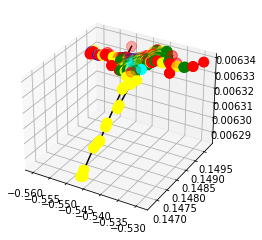

In [113]:
model.J.compute_min_connections()

model.J.draw_space()

C:\Users\joels\AppData\Local\Temp\ipykernel_2084\789969021.py:13: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


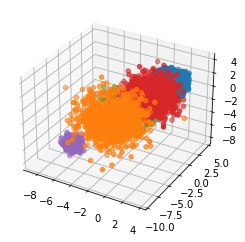

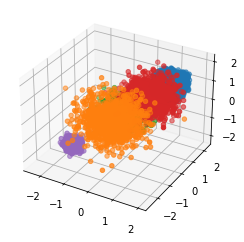

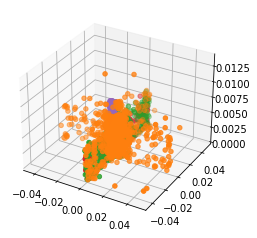

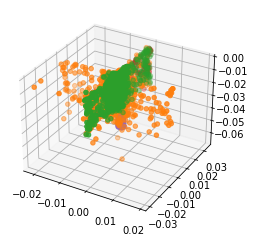

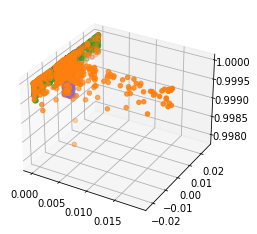

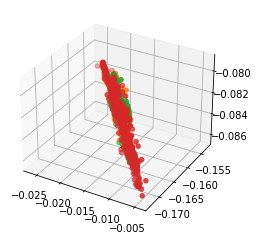

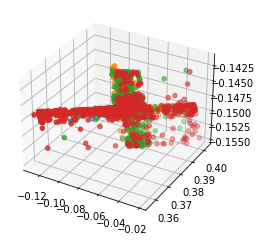

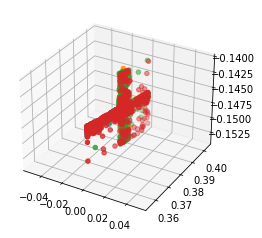

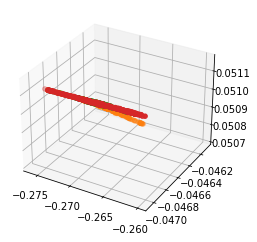

C:\Users\joels\AppData\Local\Temp\ipykernel_2084\789969021.py:29: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


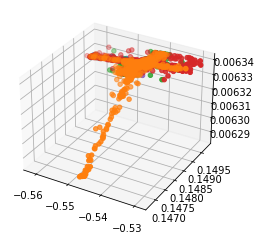

In [114]:
for layer in range(len(model.layers)):
    
    if layer-1 != -1:
        print(model.layers[layer-1])
    
    preds = []
    
    for i, p in enumerate(points):
        model.predict(p)
        preds.append(np.array(model.layers[layer].signal))
    preds = np.array(preds)
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    for i in np.unique(labels):
        if len(preds[labels == i]) != 0:
            p = preds[labels == i].reshape(preds[labels == i].shape[0], preds[labels == i].shape[1])
            ax.scatter(p.T[0], p.T[1], p.T[2])
    plt.show()
    
    
preds = []
for i, p in enumerate(points):
    preds.append(model.predict(p))
preds = np.array(preds).reshape(len(preds), len(preds[0]))

print(model.layers[-1])

fig = plt.figure()
ax = fig.gca(projection='3d')
for i in np.unique(labels):
    p = preds[labels == i]
    ax.scatter(p.T[0], p.T[1], p.T[2])
plt.show()

In [115]:
print(model.layers[0].W)
print(model.layers[1].W)


[-1.9280602263750495, 2.85072273190639]
[[           0.321            0.073            0.178            0.407]
 [           0.340           -0.178            0.173           -0.028]
 [          -0.019            0.075            0.026            0.264]
 [           0.138            0.022            0.081            0.061]
 [           0.272           -0.037            0.057           -0.155]
 [          -0.464            0.119            0.157           -0.135]]


In [ ]:
model.train(points, labels, alpha = 0.0003, epochs = 1000, batch_size=256)   

C:\Users\joels\AppData\Local\Temp\ipykernel_2084\2911018045.py:35: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


In [ ]:
print(model.layers[0].W)
print(model.layers[1].W)

In [ ]:
for layer in range(len(model.layers)):
    
    if layer-1 != -1:
        print(model.layers[layer-1])
    
    preds = []
    
    for i, p in enumerate(points):
        model.predict(p)
        preds.append(np.array(model.layers[layer].signal))
    preds = np.array(preds)
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    for i in np.unique(labels):
        if len(preds[labels == i]) != 0:
            p = preds[labels == i].reshape(preds[labels == i].shape[0], preds[labels == i].shape[1])
            ax.scatter(p.T[0], p.T[1], p.T[2])
    plt.show()
    
    
preds = []
for i, p in enumerate(points):
    preds.append(model.predict(p))
preds = np.array(preds).reshape(len(preds), len(preds[0]))

print(model.layers[-1])

fig = plt.figure()
ax = fig.gca(projection='3d')
for i in np.unique(labels):
    p = preds[labels == i]
    ax.scatter(p.T[0], p.T[1], p.T[2])
plt.show()

In [ ]:
preds = []
for i, p in enumerate(points):
    preds.append(model.predict(p))
    
preds = np.array(preds)
model.J.set_latent_points(preds[:1000])
model.J.batch_y_t = labels[:1000]


In [ ]:
acc = []
for p, l in zip(preds, labels):
    acc.append(l == np.argmax(model.J.evaluate(p)))
    print(np.argmax(model.J.evaluate(p)), l)
acc = np.array(acc, dtype = "int")
print(sum(acc)/len(acc))

In [ ]:
model.J.compute_min_connections()

model.J.draw_space()

x = np.multiply(np.random.random_sample((300, inp_size)), np.random.random_integers(0, 5))
y = np.sum(x, axis = 1)
print(x[0].shape, y[0])

model.train(x, y, alpha = 0.003, batch_size= 50, epochs = 10)

for i, j in zip(x, y):
    p = model.predict(i)
    print(p, j, (p-j) * (p-j))

"""
errors = []
for i in range(len(x)):
    pred = model.predict(x[i])
    #print("Model, out_signal:", model.layers[-1].W.dot(np.append(x, 1)))
    print("pred:", pred)
    print("True_", y[i])
    if sum(pred) == 0:
        print(model.layers[-1].gradients)
    
    errors.append(np.sum(model.compute_gradient(x[i], y[i])))
    model.update_layers(alpha = 0.003)
    print()
    #print(model.layers[-1].gradients)
print(np.argmin(errors))
print(y[0])

plt.plot(errors)

plt.show()
"""

In [521]:
np.random.seed(0)
c = MSE()
model = make_model(c)

In [522]:
model.get_size()

0
12
0
0
12
0
0
12
3


39

(3000, 3)


C:\Users\joels\AppData\Local\Temp\ipykernel_27948\1426817876.py:9: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


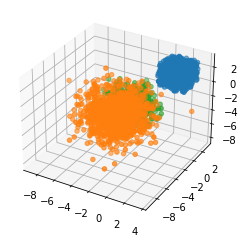

(3000, 4)


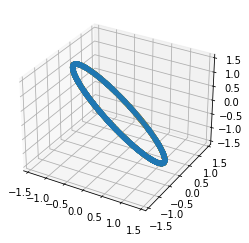

(3000, 3)


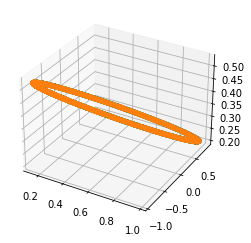

(3000, 3)


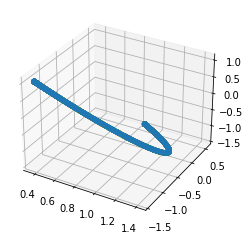

(3000, 4)


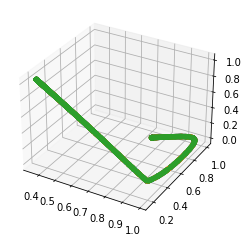

(3000, 3)


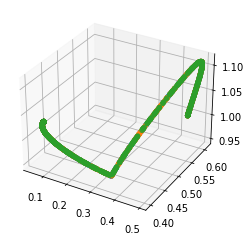

(3000, 3)


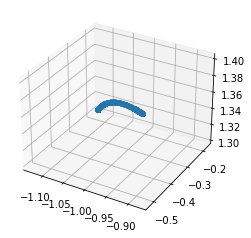

(3000, 4)


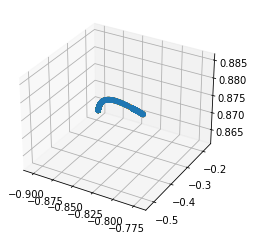

(3000, 3, 1)


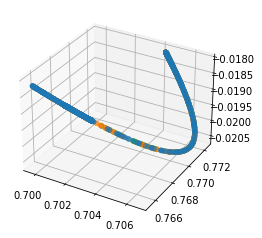

(3000, 3)


C:\Users\joels\AppData\Local\Temp\ipykernel_27948\1426817876.py:25: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


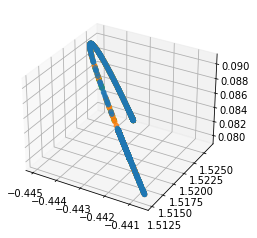

In [525]:
for layer in range(len(model.layers)):
    preds = []
    for i, p in enumerate(points):
        model.predict(p)
        preds.append(np.array(model.layers[layer].signal))
    preds = np.array(preds)
    print(preds.shape)
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    for i in np.unique(labels):
        if len(preds[labels == i]) != 0:
            p = preds[labels == i].reshape(preds[labels == i].shape[0], preds[labels == i].shape[1])
            ax.scatter(p.T[0], p.T[1], p.T[2])
    plt.show()
    
    
preds = []
for i, p in enumerate(points):
    preds.append(model.predict(p))
preds = np.array(preds).reshape(len(preds), len(preds[0]))

print(preds.shape)

fig = plt.figure()
ax = fig.gca(projection='3d')
for i in np.unique(labels):
    p = preds[labels == i]
    ax.scatter(p.T[0], p.T[1], p.T[2])
plt.show()

In [529]:
model.train(points, labels, alpha = 0.0003, epochs = 200, batch_size=256)   

(3000, 3)


C:\Users\joels\AppData\Local\Temp\ipykernel_27948\1426817876.py:9: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


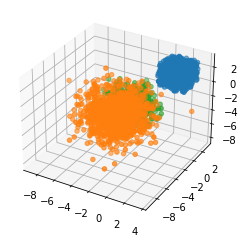

(3000, 4)


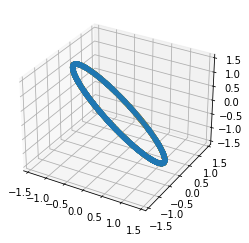

(3000, 3)


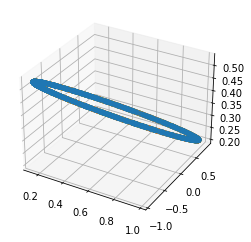

(3000, 3)


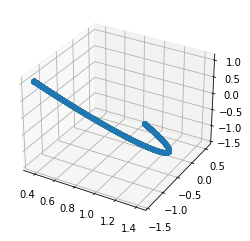

(3000, 4)


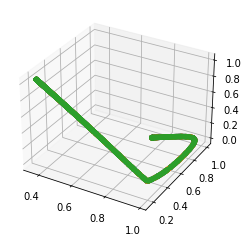

(3000, 3)


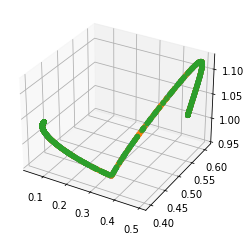

(3000, 3)


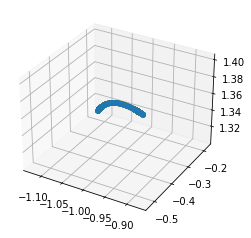

(3000, 4)


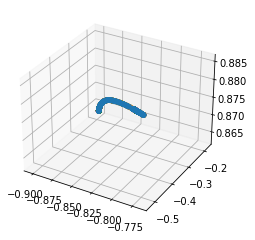

(3000, 3, 1)


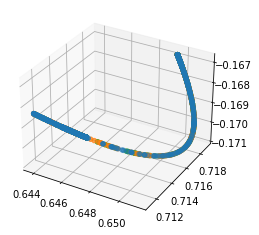

(3000, 3)


C:\Users\joels\AppData\Local\Temp\ipykernel_27948\1426817876.py:25: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


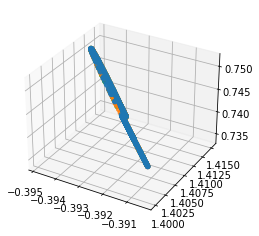

In [528]:
for layer in range(len(model.layers)):
    preds = []
    for i, p in enumerate(points):
        model.predict(p)
        preds.append(np.array(model.layers[layer].signal))
    preds = np.array(preds)
    print(preds.shape)
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    for i in np.unique(labels):
        if len(preds[labels == i]) != 0:
            p = preds[labels == i].reshape(preds[labels == i].shape[0], preds[labels == i].shape[1])
            ax.scatter(p.T[0], p.T[1], p.T[2])
    plt.show()
    
    
preds = []
for i, p in enumerate(points):
    preds.append(model.predict(p))
preds = np.array(preds).reshape(len(preds), len(preds[0]))

print(preds.shape)

fig = plt.figure()
ax = fig.gca(projection='3d')
for i in np.unique(labels):
    p = preds[labels == i]
    ax.scatter(p.T[0], p.T[1], p.T[2])
plt.show()